# 이상치와 예상치 못한 값을 식별하는 함수
- 재사용의 효용이 가장 큰 것 : 사전 가정이 극단보다는 분포의 중심경향성인 경우가 많기 때문

### 변수 분포 확인, 극단값 나열, 분포 시각화 함수 작성

In [1]:
import pandas as pd
import os
import sys
import pprint

In [3]:
nls97 = pd.read_csv('data/nls97f.csv')
nls97.set_index('personid', inplace=True)
covidtotals = pd.read_csv('data/covidtotals720.csv')

### 1. 분포의 몇 가지 중요한 속성을 표시하는 함수
- 시리즈를 받음
- 중심경향성, 형상, 퍼짐의 측도 생성 ->> 이 측도를 담은 딕셔너리 반환
- 정규성에 대한 샤피로 검정이 값을 반환하지 않는 상황 처리 : 이 경우 normstat, normpvalue 키를 추가하지 않음

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as scistat
import math

def getdistprops(seriestotest):
    out = {}
    normstat, normpvalue = scistat.shapiro(seriestotest)
    if (not math.isnan(normstat)):
        out['normstat'] = normstat
        if (normpvalue >= 0.05):
            out['normpvalue'] = str(round(normpvalue, 2)) + ": Accept Normal"
        elif (normpvalue < 0.05):
            out['normpvalue'] = str(round(normpvalue, 2)) + ": Reject Normal"
    out['mean'] = seriestotest.mean()
    out['median'] = seriestotest.median()
    out['std'] = seriestotest.std()
    out['kurtosis'] = seriestotest.kurtosis()
    out['skew'] = seriestotest.skew()
    out['count'] = seriestotest.count()
    return out

#### 시리즈의 백만명당 확진자 수를 Getdistprops 함수에 전달

In [8]:
sys.path.append(os.getcwd() + "/helperfunctions")
import outliers as ol

dist = ol.getdistprops(covidtotals.total_cases_pm)

# pprint 함수는 데이터 구조를 더 읽기 쉽고 보기 좋게 출력
pprint.pprint(dist)

{'count': 209,
 'kurtosis': 26.137524276840452,
 'mean': 2297.0221435406693,
 'median': 868.866,
 'normpvalue': '0.0: Reject Normal',
 'normstat': 0.5617034435272217,
 'skew': 4.284484653881833,
 'std': 4039.840202653782}


> 정규분포에 비해 상당한 양의 치우침과 두꺼운 꼬리가 있음 <br>
샤피로 정규성 검정 결과 : 정규성 만족하지 않음

### 데이터프레임의 이상값을 나열하는 함수 작성
- sumvars의 전체 열에 대해 이터레이션
- IQR로 임계치 설정
- varname : 이상값 및 임계치 수준에 대해 검사한 변수를 가리킴
- 반환할 데이터프레임에 othervars 리스트에 열 포함 시킴

In [9]:
def getouliers(dfin, sumvars, othervars):
    dfin = dfin[sumvars + othervars]
    dfout = pd.DataFrame(columns=dfin.columns, data = None)
    
    dfsums = dfin[sumvars]
    for col in dfsums.columns:
        thirdq, firstq = dfsums[col].quantile(0.75), dfsums[col].quantile(0.25)
        interquartilerange = 1.5 * (thirdq - firstq)
        outlierhigh, outlierlow = interquartilerange + thirdq, firstq - interquartilerange
        df = dfin.loc[(dfin[col]> outlierhigh) | (dfin[col] < outlierlow)]
        df = df.assign(varname = col, threshlow = outlierlow, threshhigh = outlierhigh)
        dfout = pd.concat([dfout, df])
    return dfout

In [23]:
import importlib #(모듈 수정시)
importlib.reload(ol)

<module 'outliers' from '/Users/angela/Pandas_Data_Cleaning/helperfunctions/outliers.py'>

In [15]:
sumvars = ['satmath', 'wageincome']
othervars = ['originalid', 'highestdegree', 'gender', 'maritalstatus']

In [16]:
outliers = ol.getouliers(nls97, sumvars, othervars)

In [18]:
outliers.varname.value_counts(sort=False)

satmath        10
wageincome    260
Name: varname, dtype: int64

In [19]:
outliers.loc[outliers.varname=='satmath', othervars+sumvars]

,originalid,highestdegree,gender,maritalstatus,satmath,wageincome
223058,6696,0. None,Female,Never-married,46.0,30000.0
267254,1622,2. High School,Female,Never-married,48.0,100000.0
291029,7088,2. High School,Female,NaN,51.0,NaN
337438,159,2. High School,Female,Married,200.0,NaN
399109,3883,2. High School,Female,NaN,36.0,NaN
448463,326,4. Bachelors,Female,NaN,47.0,NaN
738290,7705,0. None,Female,NaN,7.0,NaN
748274,3394,4. Bachelors,Male,Married,42.0,NaN
799095,535,5. Masters,Female,Never-married,59.0,120000.0
955430,2547,2. High School,Female,Married,200.0,NaN


In [20]:
outliers.to_excel('views/nlsoutliers.xlsx')

### 히스토그램과 박스플롯 생성하는 함수

In [22]:
def makeplot(seriestoplot, title, xlabel, plottype='hist'):
    if (plottype=='hist'):
        plt.hist(seriestoplot)
        plt.axvline(seriestoplot.mean(), color='red', linestyle='dashed', linewidth=1)
        plt.xlabel(xlabel)
        plt.ylabel('Frequency')
    elif (plottype == 'box'):
        plt.boxplot(seriestoplot.dropna(), labels=[xlabel])
    plt.title(title)
    plt.show()

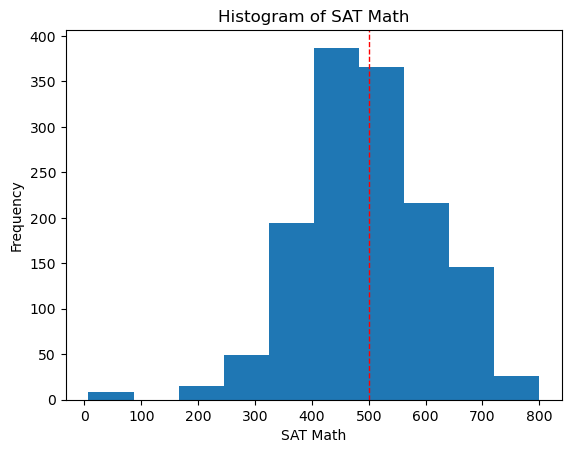

In [24]:
ol.makeplot(nls97.satmath, "Histogram of SAT Math", "SAT Math")

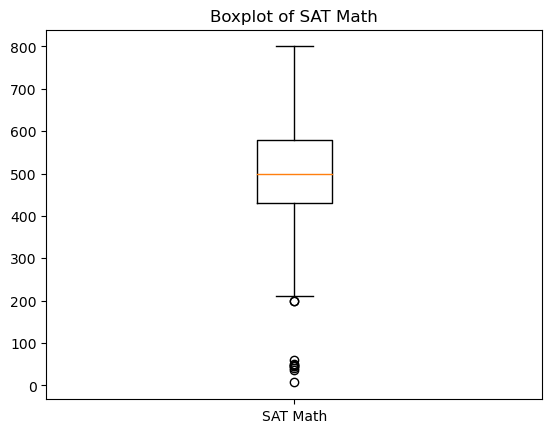

In [25]:
ol.makeplot(nls97.satmath, "Boxplot of SAT Math", "SAT Math", "box")